In [19]:
!python -V

Python 3.9.12


In [20]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [21]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')

In [22]:
mlflow.set_experiment("my-first-ever-mlflow-experiment")

<Experiment: artifact_location='/workspaces/mlops-try/02-experiment-tracking/mlruns/1', creation_time=1748269299441, experiment_id='1', last_update_time=1748269299441, lifecycle_stage='active', name='my-first-ever-mlflow-experiment', tags={}>

In [23]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [24]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775464278878395

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


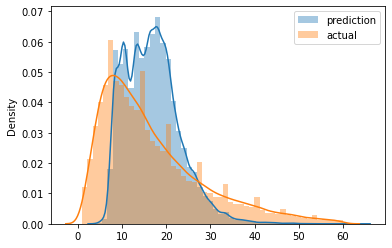

In [25]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [26]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [27]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [28]:
len(df_train), len(df_val)


(73908, 61921)

In [29]:

df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [30]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [31]:

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [32]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.4793657829373155

In [33]:

with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [34]:
with mlflow.start_run():
	mlflow.set_tag("developper", "meeeeee")
	mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
	mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

	alpha = 0.1
	mlflow.log_param("alpha", alpha)
	lr = Lasso(alpha)
	lr.fit(X_train, y_train)

	y_pred = lr.predict(X_val)

	rmse = mean_squared_error(y_val, y_pred, squared=False)
	mlflow.log_metric("rmse", rmse)

	mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path="model_pickle")


In [35]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [36]:
"""def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}"""

'def objective(params):\n    with mlflow.start_run():\n        mlflow.set_tag("model", "xgboost")\n        mlflow.log_params(params)\n        booster = xgb.train(\n            params=params,\n            dtrain=train,\n            num_boost_round=1000,\n            evals=[(valid, \'validation\')],\n            early_stopping_rounds=50\n        )\n        y_pred = booster.predict(valid)\n        rmse = mean_squared_error(y_val, y_pred, squared=False)\n        mlflow.log_metric("rmse", rmse)\n\n    return {\'loss\': rmse, \'status\': STATUS_OK}'

In [37]:
"""search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)"""

"search_space = {\n    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),\n    'learning_rate': hp.loguniform('learning_rate', -3, 0),\n    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),\n    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),\n    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),\n    'objective': 'reg:linear',\n    'seed': 42\n}\n\nbest_result = fmin(\n    fn=objective,\n    space=search_space,\n    algo=tpe.suggest,\n    max_evals=50,\n    trials=Trials()\n)"

In [38]:
"""params = {
	"learning_rate": 0.22093207255173006,
	"max_depth": 43,
	"min_child_weight" :2.98274675380116,
	"objective":  "reg:linear",
	"reg_alpha": 0.12234284295963546,
	"reg_lambda":0.17958531299020217,
	"seed": 42
}
mlflow.autolog()
mlflow.xgboost.autolog(log_datasets=False)

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)"""

'params = {\n\t"learning_rate": 0.22093207255173006,\n\t"max_depth": 43,\n\t"min_child_weight" :2.98274675380116,\n\t"objective":  "reg:linear",\n\t"reg_alpha": 0.12234284295963546,\n\t"reg_lambda":0.17958531299020217,\n\t"seed": 42\n}\nmlflow.autolog()\nmlflow.xgboost.autolog(log_datasets=False)\n\nbooster = xgb.train(\n    params=params,\n    dtrain=train,\n    num_boost_round=1000,\n    evals=[(valid, \'validation\')],\n    early_stopping_rounds=50\n)'

In [41]:
with mlflow.start_run():
	b_params = {
	"learning_rate": 0.22093207255173006,
	"max_depth": 43,
	"min_child_weight" :2.98274675380116,
	"objective":  "reg:linear",
	"reg_alpha": 0.12234284295963546,
	"reg_lambda":0.17958531299020217,
	"seed": 42
	}
	
	mlflow.log_params(b_params)

	booster = xgb.train(
    params=b_params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
	)

	y_pred = booster.predict(valid)
	rmse = mean_squared_error(y_val, y_pred, squared=False)
	mlflow.log_metric("rmse", rmse)

	with open("models/preprocessor.b", "wb") as f_out:
		   pickle.dump(dv, f_out)
	
	mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
	mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:13:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.46699
[1]	validation-rmse:9.22557
[2]	validation-rmse:8.36001
[3]	validation-rmse:7.76660
[4]	validation-rmse:7.36635
[5]	validation-rmse:7.09849
[6]	validation-rmse:6.91818
[7]	validation-rmse:6.79662
[8]	validation-rmse:6.71007
[9]	validation-rmse:6.65083
[10]	validation-rmse:6.60692
[11]	validation-rmse:6.57743
[12]	validation-rmse:6.55422
[13]	validation-rmse:6.53669
[14]	validation-rmse:6.52291
[15]	validation-rmse:6.51229
[16]	validation-rmse:6.50189
[17]	validation-rmse:6.49546
[18]	validation-rmse:6.49053
[19]	validation-rmse:6.48548
[20]	validation-rmse:6.48058
[21]	validation-rmse:6.47618
[22]	validation-rmse:6.47366
[23]	validation-rmse:6.47200
[24]	validation-rmse:6.46859
[25]	validation-rmse:6.46586
[26]	validation-rmse:6.46360
[27]	validation-rmse:6.46124
[28]	validation-rmse:6.45976
[29]	validation-rmse:6.45758
[30]	validation-rmse:6.45572
[31]	validation-rmse:6.45379
[32]	validation-rmse:6.45169
[33]	validation-rmse:6.45039
[34]	validation-rmse:6.

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:15:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/26 18:15:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpxoag1lza/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 
2025/05/26 18:15:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [42]:
logged_model = 'runs:/461acd96d8af429b886168cb63db3b72/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



In [44]:
xgboost_model = mlflow.xgboost.load_model('runs:/461acd96d8af429b886168cb63db3b72/models_mlflow')

In [45]:
xgboost_model

In [46]:
y_pred = xgboost_model.predict(valid)

In [47]:
y_pred

array([14.299607,  6.963071, 13.600258, ..., 13.568771,  5.82065 ,
        8.036267], dtype=float32)